In [17]:
import pickle
from kafka import KafkaConsumer
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_curve
import seaborn as sb
from sklearn.base import clone
from copy import deepcopy
from statistics import mean
import pickle
import csv

In [18]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

In [19]:
pkl_filename = "static_model.pkl"
with open(pkl_filename, 'rb') as file:
    static_model = pickle.load(file)
'''
pkl_filename = "static_model.pkl"
with open(pkl_filename, 'rb') as file:
    dynamic_model = pickle.load(file)
'''
pkl_filename = "scaler.pkl"
with open(pkl_filename, 'rb') as file:
    scaler = pickle.load(file)

pkl_filename = "mask.pkl"
with open(pkl_filename, 'rb') as file:
    features = pickle.load(file)    #Setting warm_start for retraining
dynamic_model = deepcopy(static_model)      #Creating a dynamic model

In [20]:
cols = True                             #Counters to keep track of dynamic data
l = []
counter = -1
metacounter = 0
static_score=[]
dynamic_score=[]

Retraining and Testing

In [21]:
def training(maindf):                       #Process the dataset for the model
    print("Training Again")
    maindf.drop(['u00ef\\u00bb\\u00bftimestamp'], axis=1, inplace=True)
    y = maindf['Target Attack']
    y = y.astype('int')
    X = maindf.drop(['Target Attack'], axis=1)
    X = X.loc[:, features]
    X = scaler.transform(X)
    dynamic_model.n_estimators += 50      #Add estimators to the model
    dynamic_model.fit(X, y)                 #Retrain the model
    return True

In [22]:
def testing(df, maindf):                #Testing models
    y = df['Target Attack']                 #Preprocessing data for testing models
    X = df.drop(['Target Attack'], axis=1)
    X = X.loc[:, features]
    X = scaler.transform(X)
    Y_pred = static_model.predict(X)        #static model predictions
    Y_pred_d = dynamic_model.predict(X)     #dynamic model predictions
    y = y.astype(Y_pred.dtype)
    dyn_f1_score = f1_score(Y_pred_d, y)
    stat_f1_score = f1_score(Y_pred, y)
    dynamic_score.append(dyn_f1_score)
    static_score.append(stat_f1_score)
    if(dyn_f1_score < 0.85):               #if dynamic model below threshold
        training(maindf)                    #retrain using the main dataset
        return True
    else:
        return False

Getting inputs dynamically

In [23]:
for m in consumer:
    x = m.value.decode('utf-8').strip("\"").strip("\\n").split(",")     #processing the input in bits
    counter += 1
    if(cols == True):                                   #If first input, set as columns
        column_name = x
        cols = False
        df_main = pd.DataFrame(columns=column_name)     #initializing an empty dataframe
    else:
        l.append(x)                                     #Append inputs to list
    if(counter == 1000):                                #Create batches of 1000
        metacounter += 1000
        df = pd.DataFrame(l, columns=column_name)
        l = []
        df.replace((np.Inf, -np.Inf), np.nan)       #replacing infinity values with null to drop later
        df['u00ef\\u00bb\\u00bftimestamp'] = 0      #Changing timestamp to int
        df.dropna(inplace=True)                                 #dropping null
        df['longest_word'] = df['longest_word'].str.len()       #preprocessing like in the static model
        df['sld'] = df['sld'].apply(hash)
        df = df.apply(pd.to_numeric)
        df_main = pd.concat([df_main, df], ignore_index=True)   #Add batch to exisiting dataframe
        cdf = df.copy()                                         #create a copy
        cdf.drop(['u00ef\\u00bb\\u00bftimestamp'], axis=1, inplace=True)    #drop timestamp
        retrain = testing(cdf, df_main.copy())                  #Test models on batch
        if(retrain == True):                                    #if model was retrained
            df_main = pd.DataFrame(columns=column_name)         #Clear the dataframe
        counter = 0                                             #Reset counter after batch
        print(metacounter)
    if(metacounter==268000):                                    #Break if end of loop
        break
        

Training Again
1000
2000
Training Again
3000
4000
Training Again
5000
6000
7000
Training Again
8000
9000
10000
11000
12000
13000
Training Again
14000
15000
16000
Training Again
17000
Training Again
18000
19000
20000
Training Again
21000
22000
Training Again
23000
Training Again
24000
25000
26000
27000
28000
29000
30000
Training Again
31000
Training Again
32000
33000
Training Again
34000
35000
Training Again
36000
37000
38000
39000
40000
41000
42000
Training Again
43000
Training Again
44000
45000
46000
47000
48000
Training Again
49000
50000
Training Again
51000
52000
53000
Training Again
54000
Training Again
55000
Training Again
56000
Training Again
57000
58000
59000
60000
Training Again
61000
62000
63000
64000
Training Again
65000
66000
67000
68000
69000
70000
71000
72000
Training Again
73000
74000
Training Again
75000
Training Again
76000
Training Again
77000
78000
79000
80000
81000
82000
Training Again
83000
84000
85000
86000
Training Again
87000
88000
89000
90000
91000
92000
93000
T

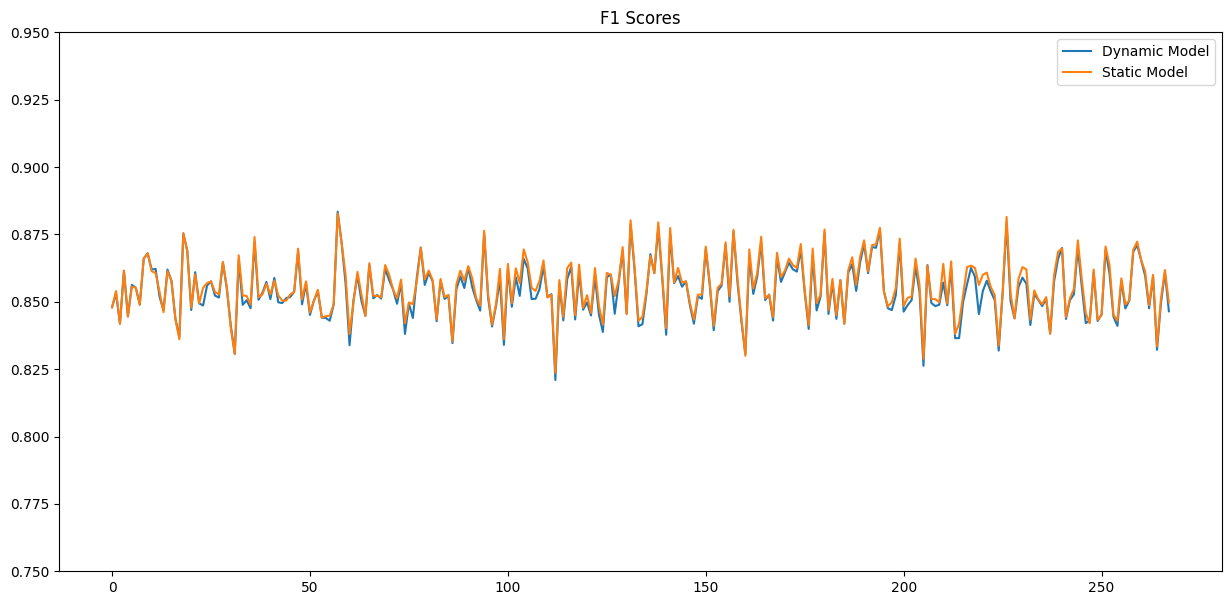

In [25]:
plt.figure(figsize=(15,7))
plt.plot(range(268), dynamic_score, label='Dynamic Model')
plt.plot(range(268), static_score, label='Static Model')
plt.ylim(0.75,0.95)
plt.title('F1 Scores')
plt.legend()
plt.show()